# Check LWD filled with ERA5

https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels

#### ERA5 hourly data on single levels from 1940 to present

- **Radiation and heat** / Surface net solar radiation
- **Radiation and heat** / Surface net solar thermal downwards
- **Radiation and heat** / Surface solar thermal downwards: `f88e980e24b1ba4fe8b42cb557ff66ae.nc`
- **Radiation and heat** / Surface solar radiation downwards: `8ef1b5ef403bac84d5778e9bf4b7e26f.nc`
- **Mean rates** / Mean surface downward long-wave radiation flux (test 2019): `23122b75afc3c080d1f85c7b5539b12f.nc`

Note: Mean rates = Radiation and heat/3600



------- 73.35 ------  
-80.05 ------- -79.8    
------- 73.1 ------  

(get 4 closest grid cells)

Downloaded by Mickaël Lalande 27/03/2025
  

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xskillscore as xs
import calendar
import os

In [2]:
# Bylot TUNDRA station (Domine et al., 2021: https://essd.copernicus.org/articles/13/4331/2021/)
lat = 73.1504
lon = -80.0046

In [3]:
path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/ERA5'

## Surface short-wave (solar) radiation downwards

In [42]:
ds = xr.open_mfdataset(path+'/SW_down/*.nc')
ds.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 107110, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 2MB 0.0 ... 6.123e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [254]:
# ds = xr.open_dataset(path+'/8ef1b5ef403bac84d5778e9bf4b7e26f.nc')
# ds

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 54526, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 436kB 2019-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 872kB ...
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 872kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-26T22:43 GRIB to CDM+CF via cfgrib-0.9.1...

### Add Bylot TUNDRA coordinates

In [43]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 2)> Size: 16B
array([73.35, 73.1 ])
Coordinates:
    number    int64 8B 0
  * latitude  (latitude) float64 16B 73.35 73.1
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [44]:
# Ajouter les nouvelles coordonnées
new_lats = np.sort(np.append(ds.latitude.values, lat))
new_lons = np.sort(np.append(ds.longitude.values, lon))

In [45]:
new_lats

array([73.1   , 73.1504, 73.35  ])

In [46]:
new_lons

array([-80.05  , -80.0046, -79.8   ])

In [47]:
ds_interp = ds.interp(latitude=new_lats, longitude=new_lons)
ds_interp

<xarray.Dataset> Size: 10MB
Dimensions:     (valid_time: 107110, latitude: 3, longitude: 3)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
  * latitude    (latitude) float64 24B 73.1 73.15 73.35
  * longitude   (longitude) float64 24B -80.05 -80.0 -79.8
Data variables:
    ssrd        (valid_time, latitude, longitude) float64 8MB 0.0 ... 6.106e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [48]:
import warnings
warnings.filterwarnings('ignore')

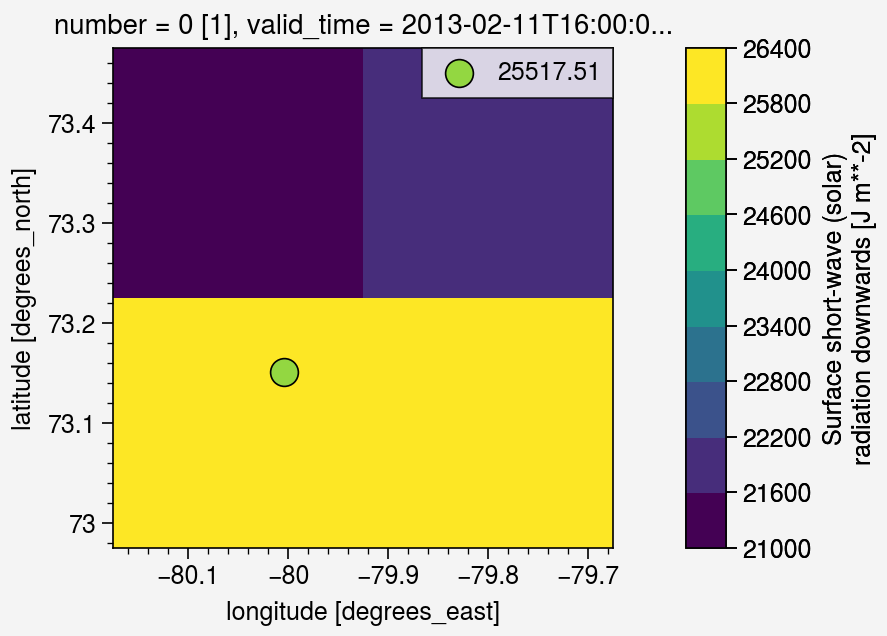

In [49]:
%matplotlib inline
fig, ax = pplt.subplots()

i_time = 1000
pcolor = ds.ssrd[i_time].plot.pcolormesh(ax=ax)

# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.ssrd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")

# Afficher la légende
ax.legend()
pplt.show()

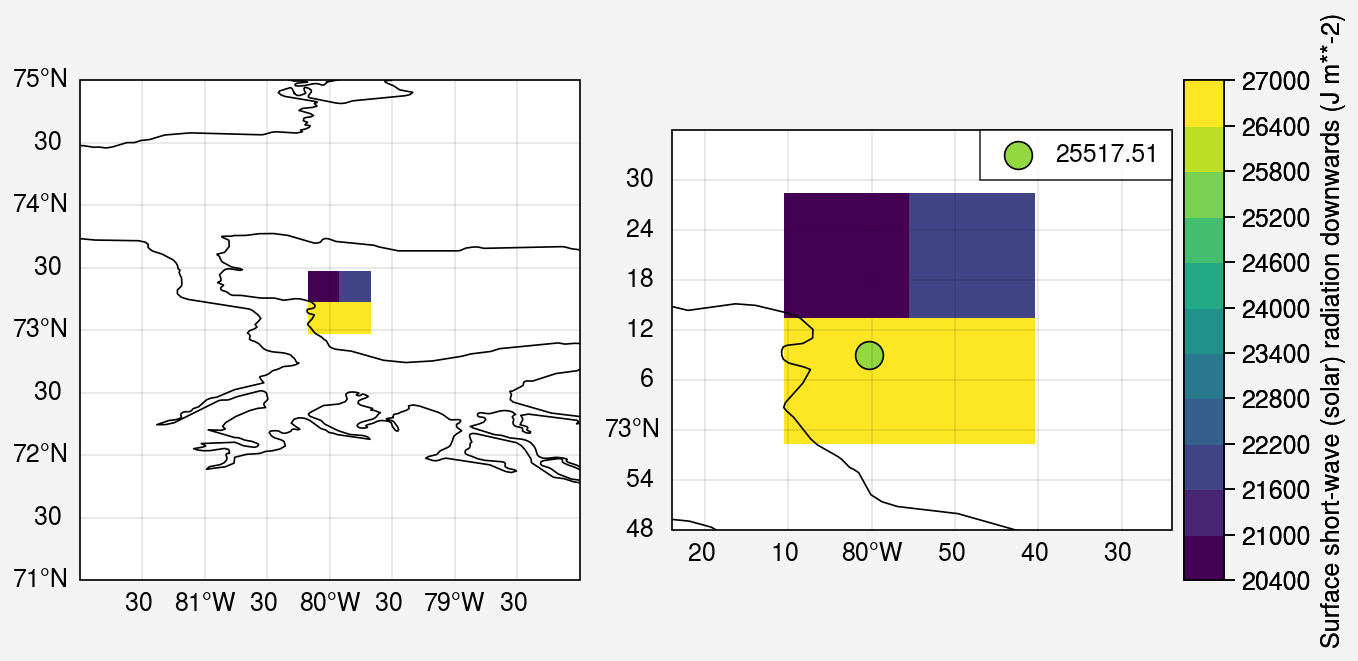

In [50]:
%matplotlib inline
fig, axs = pplt.subplots(proj='cyl', ncols=2)

i_time = 1000
ax = axs[0]
ax.pcolormesh(ds.ssrd[i_time], cmap='viridis')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(71, 75), 
    lonlim=(-82, -78),
    reso='hi'
)

ax = axs[1]
ax.pcolormesh(ds.ssrd[i_time], cmap='viridis', colorbar='r')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(72.8, 73.6), 
    lonlim=(-79.4, -80.4),
    reso='hi'
)


# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.ssrd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")
ax.legend()

#reso : {'lo', 'med', 'hi', 'x-hi', 'xx-hi'}, optional


In [51]:
ds_interp.latitude.values

array([73.1   , 73.1504, 73.35  ])

In [52]:
ds_interp.longitude.values

array([-80.05  , -80.0046, -79.8   ])

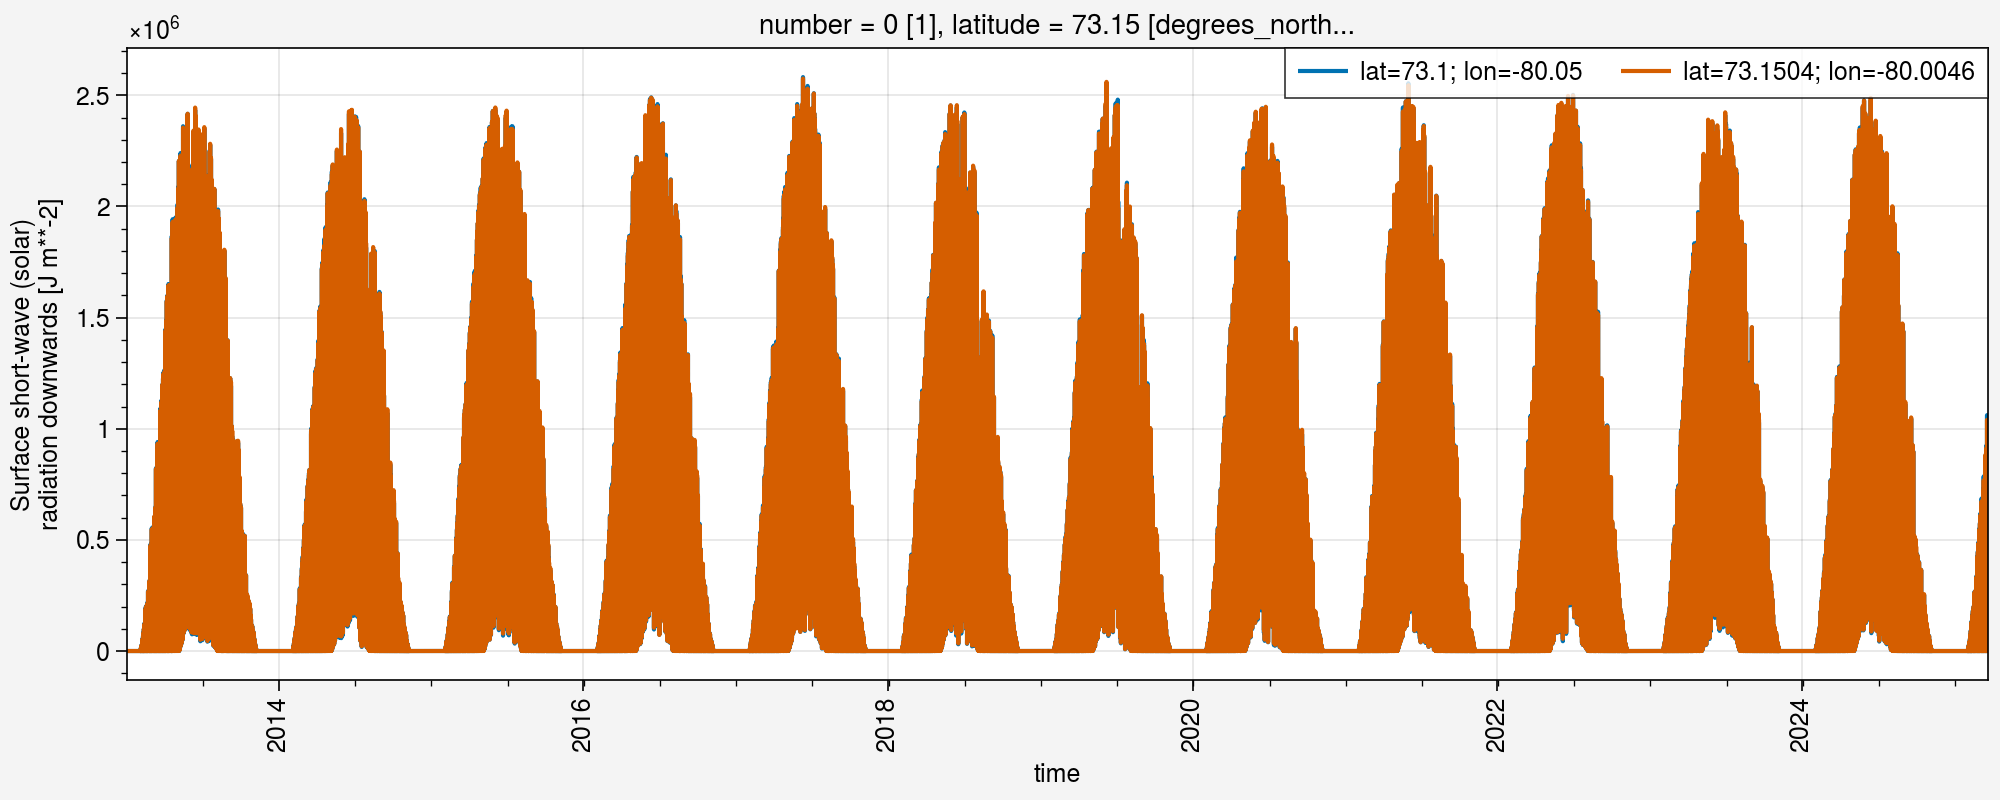

In [54]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.ssrd.sel(latitude=73.1, longitude=-80.05).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.ssrd.sel(latitude=73.1504, longitude=-80.0046).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

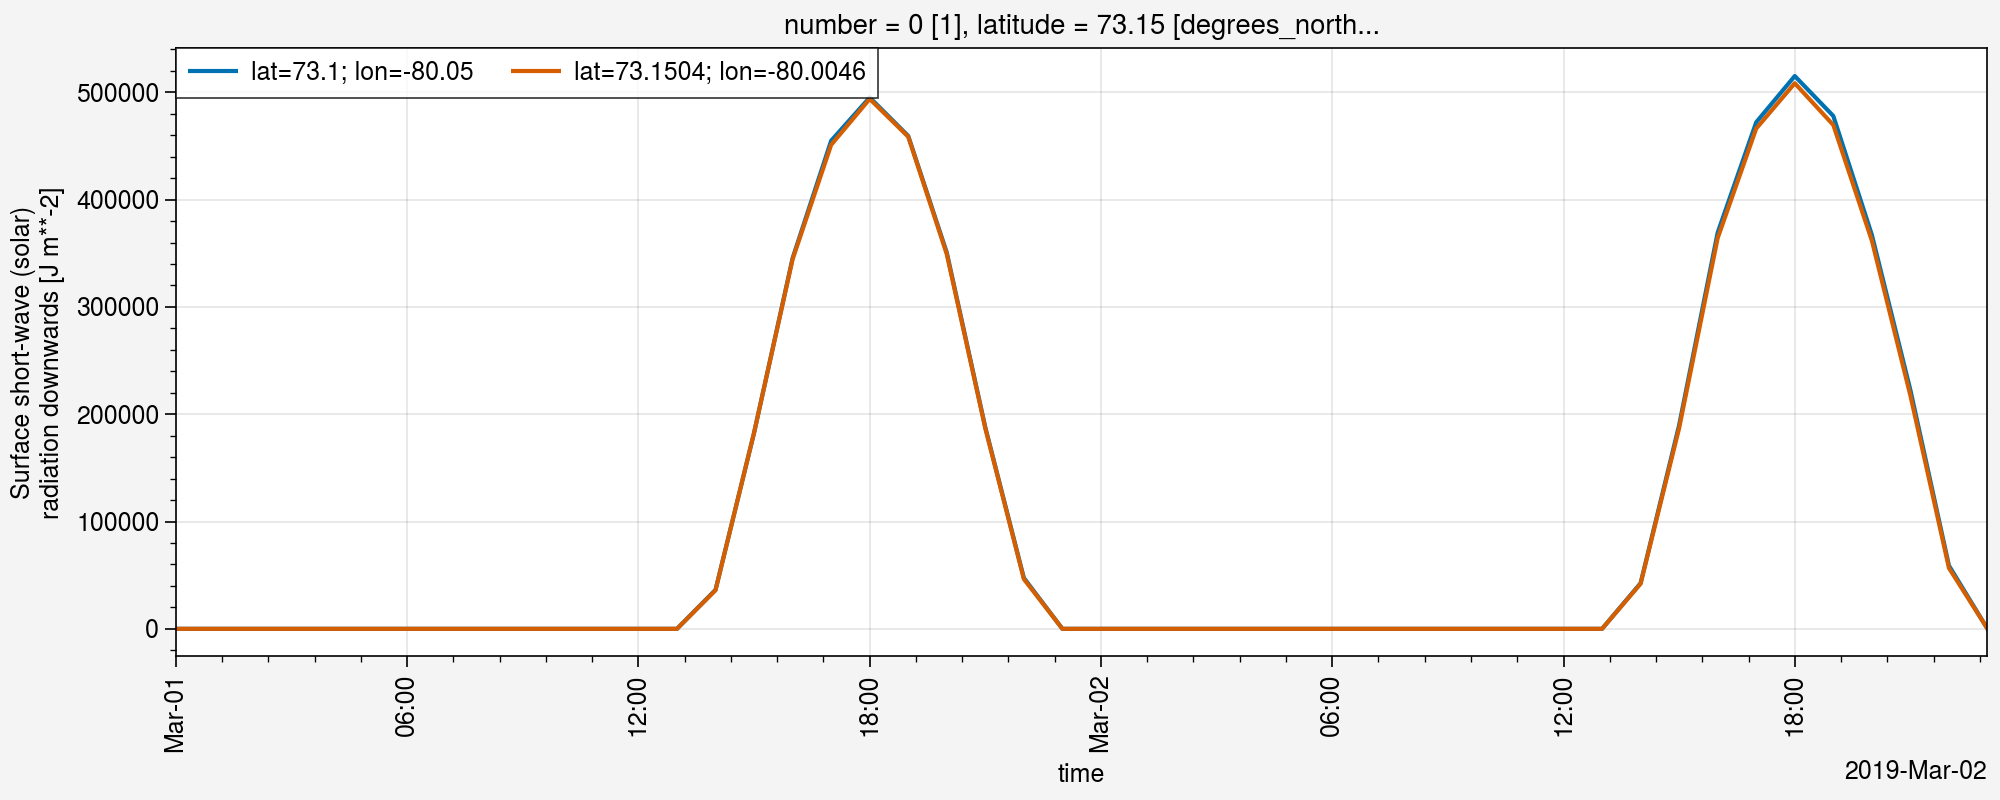

In [55]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.ssrd.sel(latitude=73.1, longitude=-80.05, valid_time=slice('2019-03-01', '2019-03-02')).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.ssrd.sel(latitude=73.1504, longitude=-80.0046, valid_time=slice('2019-03-01', '2019-03-02')).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

Need to divide by 3600 to get W m-2 s-1

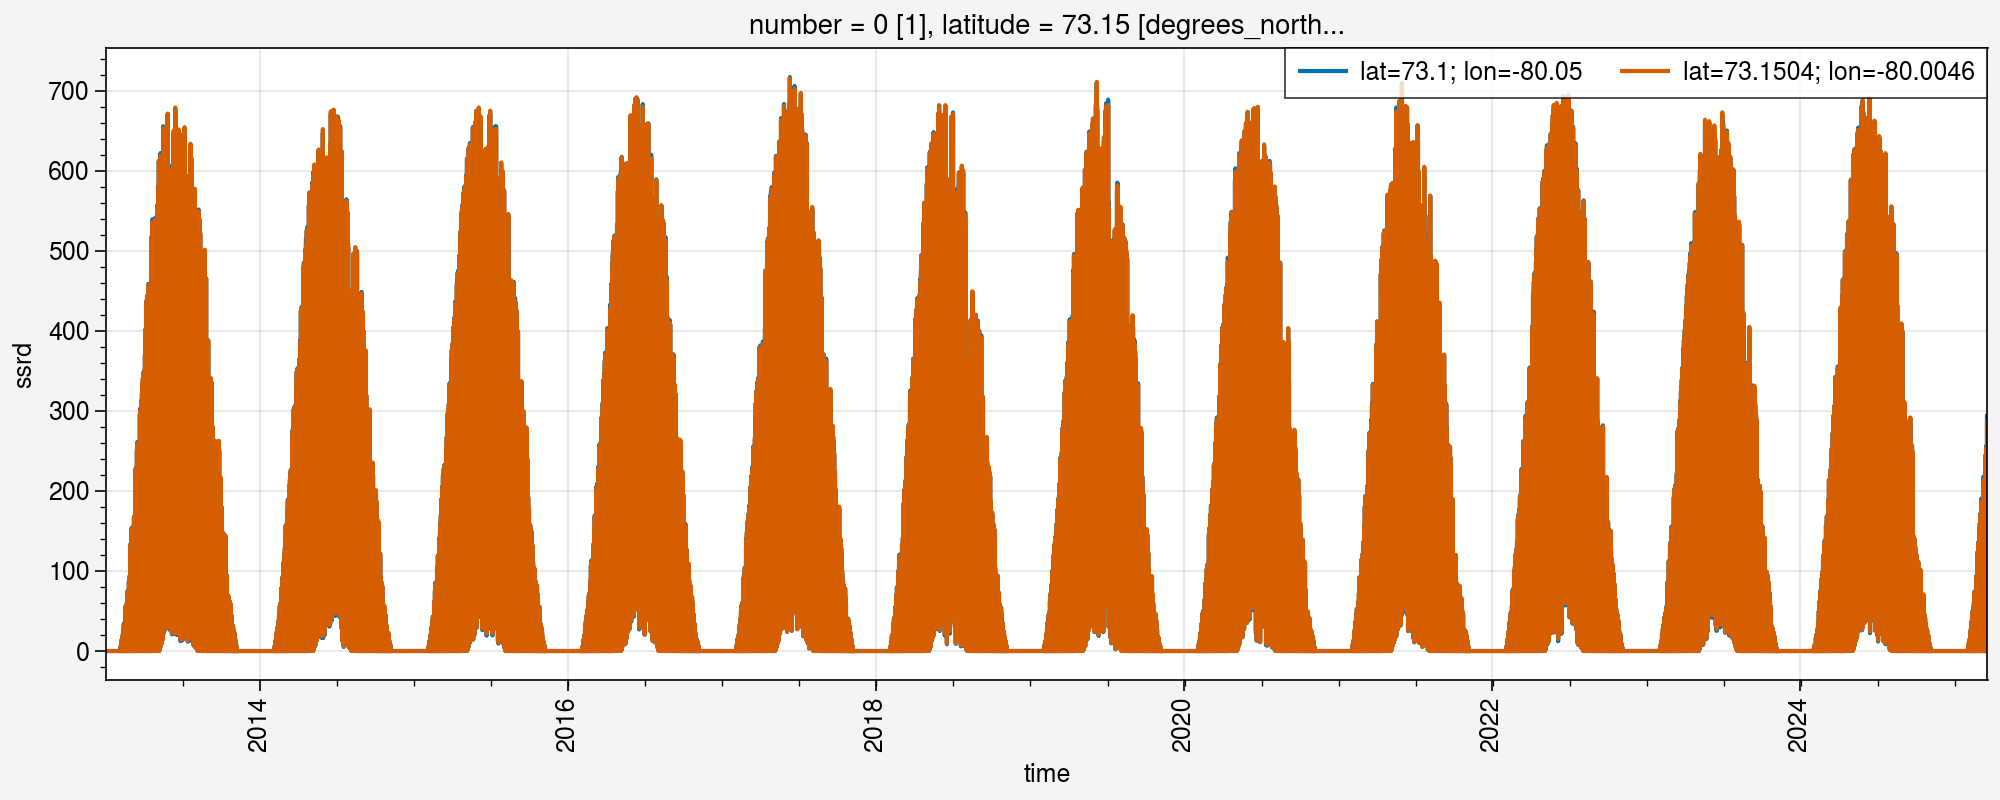

In [56]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

(ds_interp.ssrd.sel(latitude=73.1, longitude=-80.05)/3600).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
(ds_interp.ssrd.sel(latitude=73.1504, longitude=-80.0046)/3600).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

## Export data to .dat or .csv 
Only pixel including Bylot and interpolated values

In [57]:
ds_interp_out = ds_interp.ssrd.drop('number').drop('expver').rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})
ds_interp_out = ds_interp_out/3600
ds_interp_out.attrs = {'long_name': 'Surface short-wave (solar) radiation downwards', 'name': 'ssrd', 'units': 'W m$^{-2}$ s$^{-1}$'}

ds_interp_out_grid = ds_interp_out.sel(lat=73.1, lon=-80.05)
ds_interp_out_interp = ds_interp_out.sel(lat=73.1504, lon=-80.0046)
ds_interp_out_interp

<xarray.DataArray 'ssrd' (time: 107110)> Size: 857kB
array([  0.        ,   0.        ,   0.        , ..., 259.57608686,
       232.3352197 , 174.27779114])
Coordinates:
  * time     (time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T21:00:00
    lat      float64 8B 73.15
    lon      float64 8B -80.0
Attributes:
    long_name:  Surface short-wave (solar) radiation downwards
    name:       ssrd
    units:      W m$^{-2}$ s$^{-1}$

In [58]:
df_grid = ds_interp_out_grid.to_dataframe()
df_grid

,lat,lon,ssrd
time,,,
2013-01-01 00:00:00,73.1,-80.05,0.000000
2013-01-01 01:00:00,73.1,-80.05,0.000000
2013-01-01 02:00:00,73.1,-80.05,0.000000
2013-01-01 03:00:00,73.1,-80.05,0.000000
2013-01-01 04:00:00,73.1,-80.05,0.000000
...,...,...,...
2025-03-21 17:00:00,73.1,-80.05,238.899826
2025-03-21 18:00:00,73.1,-80.05,273.209115
2025-03-21 19:00:00,73.1,-80.05,262.037083


In [59]:
df_grid.to_csv(path+'/ERA5_h_ssrd_73.1N_80.05W_2013-2025_Bylot_UTC.csv')

In [60]:
df_interp = ds_interp_out_interp.to_dataframe()
df_interp

,lat,lon,ssrd
time,,,
2013-01-01 00:00:00,73.1504,-80.0046,0.000000
2013-01-01 01:00:00,73.1504,-80.0046,0.000000
2013-01-01 02:00:00,73.1504,-80.0046,0.000000
2013-01-01 03:00:00,73.1504,-80.0046,0.000000
2013-01-01 04:00:00,73.1504,-80.0046,0.000000
...,...,...,...
2025-03-21 17:00:00,73.1504,-80.0046,234.778671
2025-03-21 18:00:00,73.1504,-80.0046,270.313973
2025-03-21 19:00:00,73.1504,-80.0046,259.576087


In [61]:
df_interp.to_csv(path+'/ERA5_h_ssrd_73.1504N_80.0046W_2013-2025_Bylot_interp_UTC.csv')